In [1]:
import os
import string
import MDAnalysis as md
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from scipy.stats import f_oneway, pearsonr, ttest_ind
import matplotlib.ticker as ticker


In [2]:
def avgNestedLists(nested_vals):
    """
    Averages a 2-D array and returns a 1-D array of all of the columns
    averaged together, regardless of their dimensions.
    """
    output = []
    maximum = 0
    for lst in nested_vals:
        if len(lst) > maximum:
            maximum = len(lst)
    for index in range(maximum): # Go through each index of longest list
        temp = []
        for lst in nested_vals: # Go through each list
            if index < len(lst): # If not an index error
                temp.append(lst[index])
        output.append(np.nanmean(temp))
    return output

In [3]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
plt.rcParams["figure.figsize"] = cm2inch(10,10)
plt.rcParams.update({'font.size':10})
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [4]:
systems=["IA","PA","FA_G-prot","FA_no_G-prot"]
#systems=["FA_G-prot","IA","PA"]

In [5]:
lipid_dir = {"FA_G-prot":"POPC, POPS, POPA, POPG, POPE, CHOL, DPG3, DPSM, PAP6",
            "FA_no_G-prot":"POPC, POPS, POPA, POPG, POPE, CHOL, DPG3, DPSM, PAP6",
            "IA":"POPC, POPS, POPA, POPG, POPE, CHOL, DPG3, DPSM, PAP6",
            "PA":"POPC, POPS, POPA, POPG, POPE, CHOL, DPG3, DPSM, PAP6"}

# Frist shell

In [6]:
@jit
def count_lipids (u, lipid, stride=2):
    '''Counts the number of lipids within a shell of 0.7 nm of the TMD'''
    tot_frames = len(u.trajectory[::stride])
    O = np.zeros([tot_frames])
    
    for idx, ts in enumerate(u.trajectory[::stride]):
        sel = u.select_atoms('resname {0:s} and global around 7 resid 106-394'.format(lipid))
        num_contacts = np.unique(sel.resids).shape[0]
        O[idx] = num_contacts
    return O

In [7]:
for idx, s in enumerate(systems):
    lipids = lipid_dir[s]
    for r in range(3): 
        gro = 'TPR/{0:s}_{1:d}_nowat.tpr'.format(s,r)
        xtc = 'XTC/{0:s}_{1:d}_nowat_res_center_fit.xtc'.format(s,r)
        u = md.Universe(gro,xtc)
        for lipid in lipids.split(','):
            print ('lipid:', lipid)
            llipid = lipid.translate({ord(c): None for c in string.whitespace})
            if os.path.exists('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,r,llipid)):
                print ("{0:s} exists".format('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,r,llipid)))
                continue
            else:
                O = count_lipids(u, lipid)
                np.savetxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,r,llipid), O)

lipid: POPC
COUNTS/IA_0_number_of_POPC_within_0.7-nm.txt exists
lipid:  POPS
COUNTS/IA_0_number_of_POPS_within_0.7-nm.txt exists
lipid:  POPA
COUNTS/IA_0_number_of_POPA_within_0.7-nm.txt exists
lipid:  POPG
COUNTS/IA_0_number_of_POPG_within_0.7-nm.txt exists
lipid:  POPE
COUNTS/IA_0_number_of_POPE_within_0.7-nm.txt exists
lipid:  CHOL
COUNTS/IA_0_number_of_CHOL_within_0.7-nm.txt exists
lipid:  DPG3
COUNTS/IA_0_number_of_DPG3_within_0.7-nm.txt exists
lipid:  DPSM
COUNTS/IA_0_number_of_DPSM_within_0.7-nm.txt exists
lipid:  PAP6
COUNTS/IA_0_number_of_PAP6_within_0.7-nm.txt exists
lipid: POPC
COUNTS/IA_1_number_of_POPC_within_0.7-nm.txt exists
lipid:  POPS
COUNTS/IA_1_number_of_POPS_within_0.7-nm.txt exists
lipid:  POPA
COUNTS/IA_1_number_of_POPA_within_0.7-nm.txt exists
lipid:  POPG
COUNTS/IA_1_number_of_POPG_within_0.7-nm.txt exists
lipid:  POPE
COUNTS/IA_1_number_of_POPE_within_0.7-nm.txt exists
lipid:  CHOL
COUNTS/IA_1_number_of_CHOL_within_0.7-nm.txt exists
lipid:  DPG3
COUNTS/IA_1_nu

In [7]:
unique_lipids = ["POPC", "POPS", "POPA", "POPG", "POPE", "CHOL", "DPG3", "DPSM", "PAP6"]
systems=["IA","PA","FA_G-prot","FA_no_G-prot"]
color_systems = ["#66c2a5","#fc8d62","#8da0cb","#e78ac3"]
line_style = ["solid", "dotted", "dashed"]
color_rep = ["#1b9e77","#d95f02","#7570b3"]

IA


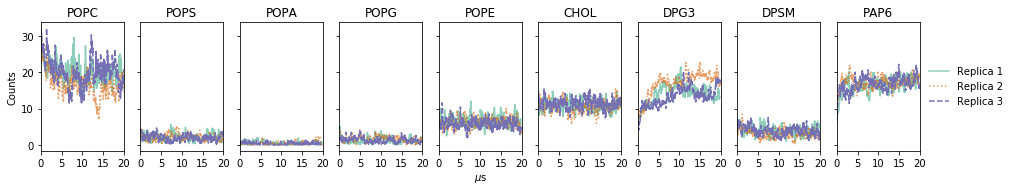

PA


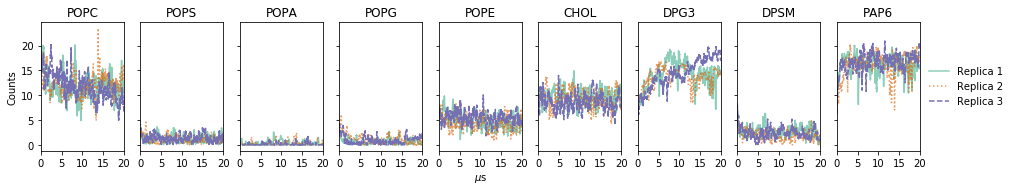

FA_G-prot


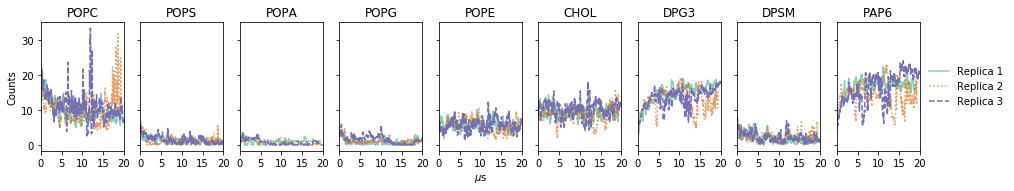

FA_no_G-prot


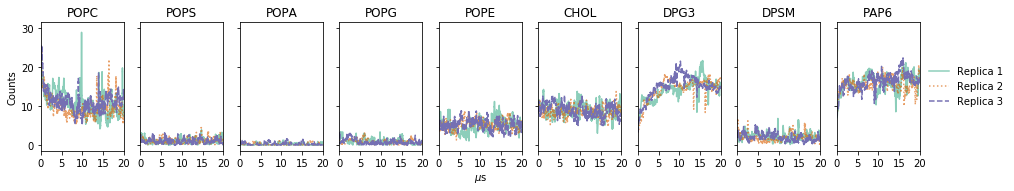

In [9]:
N = 100
for sdx, s in enumerate(systems):
    print(s)
    fig, ax = plt.subplots(ncols=9, sharey=True, sharex=True, figsize=(cm2inch(40,6)))
    for ldx, lipid in enumerate(unique_lipids):
        #print (lipid)
        c1 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,0,lipid))
        c2 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,1,lipid))
        c3 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,2,lipid))
        ax[ldx].plot(running_mean(c1, N), color=color_rep[0], linestyle=line_style[0], alpha=0.5, label='Replica 1')
        ax[ldx].plot(running_mean(c2, N), color=color_rep[1], linestyle=line_style[1], alpha=0.6, label='Replica 2')
        ax[ldx].plot(running_mean(c3, N), color=color_rep[2], linestyle=line_style[2], label='Replica 3')
        ax[ldx].set_title(lipid)
        ax[ldx].set_xlim(0,20000)
        ax[ldx].set_xticks([0, 5000,10000, 15000, 20000])
        ax[ldx].set_xticklabels([0, 5,10,15,20])
    ax[4].set_xlabel(r'$\mu$s')
    ax[0].set_ylabel('Counts')
    ax[8].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False)
    plt.savefig('COUNTS_{0:s}.png'.format(s), dpi=300, bbox_inches='tight')
    plt.show()


In [8]:
unique_lipids[:3]

['POPC', 'POPS', 'POPA']

In [14]:
unique_lipids[3:-3]

['POPG', 'POPE', 'CHOL']

In [11]:
unique_lipids[-3:]

['DPG3', 'DPSM', 'PAP6']

In [12]:
unique_lipids

['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'DPG3', 'DPSM', 'PAP6']

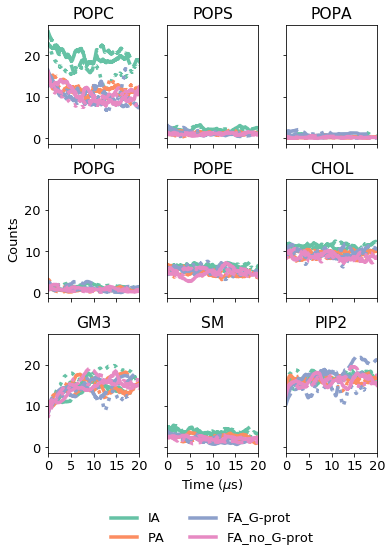

In [61]:
N = 2000
lipid_labels = ["POPC", "POPS", "POPA", "POPG", "POPE", "CHOL", "GM3", "SM", "PIP2"]
fig, ax = plt.subplots(ncols=3, nrows=3,  sharey=True, sharex=True, figsize=(cm2inch(15,20)))
lh=3.5
for sdx, s in enumerate(systems):    
    
    for ldx, lipid in enumerate(unique_lipids[:3]):
        c1 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,0,lipid))
        c2 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,1,lipid))
        c3 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,2,lipid))
        ax[0,ldx].plot(running_mean(c1, N), color=color_systems[sdx], linestyle=line_style[0], label=s, linewidth=lh)
        ax[0,ldx].plot(running_mean(c2, N), color=color_systems[sdx], linestyle=line_style[1], linewidth=lh)
        ax[0,ldx].plot(running_mean(c3, N), color=color_systems[sdx], linestyle=line_style[2], linewidth=lh)
        ax[0,ldx].set_title(lipid_labels[:3][ldx])
    for ldx, lipid in enumerate(unique_lipids[3:-3]):
        c1 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,0,lipid))
        c2 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,1,lipid))
        c3 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,2,lipid))
        ax[1,ldx].plot(running_mean(c1, N), color=color_systems[sdx], linestyle=line_style[0], label=s, linewidth=lh)
        ax[1,ldx].plot(running_mean(c2, N), color=color_systems[sdx], linestyle=line_style[1], linewidth=lh)
        ax[1,ldx].plot(running_mean(c3, N), color=color_systems[sdx], linestyle=line_style[2], linewidth=lh)
        ax[1,ldx].set_title(lipid_labels[3:-3][ldx])
    for ldx, lipid in enumerate(unique_lipids[-3:]):
        c1 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,0,lipid))
        c2 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,1,lipid))
        c3 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,2,lipid))
        ax[2,ldx].plot(running_mean(c1, N), color=color_systems[sdx], linestyle=line_style[0], label=s, linewidth=lh)
        ax[2,ldx].plot(running_mean(c2, N), color=color_systems[sdx], linestyle=line_style[1], linewidth=lh)
        ax[2,ldx].plot(running_mean(c3, N), color=color_systems[sdx], linestyle=line_style[2], linewidth=lh)
        ax[2,ldx].set_title(lipid_labels[-3:][ldx])
        
#ax[0,2].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False)
ax[2,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),
          fancybox=False, shadow=False, ncol=2, frameon=False)
ax[2,2].set_xlim(0,20000)
ax[2,2].set_xticks([0, 5000,10000, 15000, 20000])
ax[2,2].set_xticklabels([0, 5,10,15,20])
for r in range(3):
    ax[2,1].set_xlabel(r'Time ($\mu$s)')
    ax[1,0].set_ylabel('Counts')
    

fmt = '%1.0f' 
xticks = ticker.FormatStrFormatter(fmt)
for i in range(3):
    for j in range(3):
        ax[i,j].yaxis.set_major_formatter(xticks)
    
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.savefig('COUNTS_all_ver2.png', dpi=300, bbox_inches='tight')

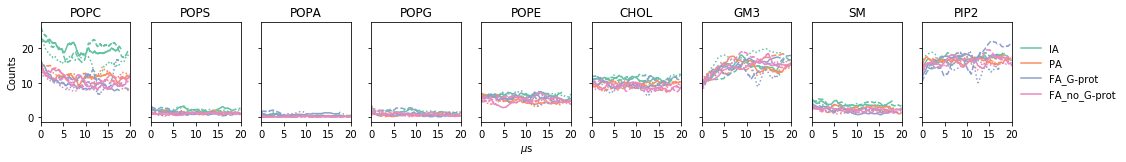

In [12]:
N = 2000
lipid_labels = ["POPC", "POPS", "POPA", "POPG", "POPE", "CHOL", "GM3", "SM", "PIP2"]
fig, ax = plt.subplots(ncols=9, sharey=True, sharex=True, figsize=(cm2inch(40,6)))
for sdx, s in enumerate(systems):    
    for ldx, lipid in enumerate(unique_lipids):
        c1 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,0,lipid))
        c2 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,1,lipid))
        c3 = np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,2,lipid))
        ax[ldx].plot(running_mean(c1, N), color=color_systems[sdx], linestyle=line_style[0], label=s)
        ax[ldx].plot(running_mean(c2, N), color=color_systems[sdx], linestyle=line_style[1])
        ax[ldx].plot(running_mean(c3, N), color=color_systems[sdx], linestyle=line_style[2])
        ax[ldx].set_title(lipid_labels[ldx])
ax[8].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False)
ax[0].set_xlim(0,20000)
ax[0].set_xticks([0, 5000,10000, 15000, 20000])
ax[0].set_xticklabels([0, 5,10,15,20])
ax[4].set_xlabel(r'$\mu$s')
ax[0].set_ylabel('Counts')
plt.tight_layout()
plt.savefig('COUNTS_all.png', dpi=300, bbox_inches='tight')

# Statistic

#### One-way ANOVA

In [11]:
for lipid in unique_lipids:
    C = []
    for s in systems:
        #print (s)
        C.append([np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,r,lipid)) for r in range(3)])
    S = np.array(C)
    f_val, p_val = f_oneway(S[0,0],S[0,1],S[0,2], 
                            S[1,0],S[1,1], S[1,2],
                            S[2,0],S[2,1],S[2,2],
                            S[3,0],S[3,1],S[3,2])
    print (lipid)
    print ('P value: ', p_val)

POPC
P value:  0.0
POPS
P value:  0.0
POPA
P value:  0.0
POPG
P value:  0.0
POPE
P value:  0.0
CHOL
P value:  0.0
DPG3
P value:  0.0
DPSM
P value:  0.0
PAP6
P value:  0.0


When the p-value is less than the significance level, the usual interpretation is that the results are statistically significant, and you reject H 0. For one-way ANOVA, you reject the null hypothesis when there is sufficient evidence to conclude that not all of the means are equal

In [12]:
for lipid in unique_lipids:
    C = []
    for s in systems:
        #print (s)
        C.append(avgNestedLists([np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,r,lipid)) for r in range(3)]))
    S = np.array(C)
    f_val, p_val = f_oneway(S[0],S[1],S[2],S[3])

    print (lipid)
    print ('P value: ', p_val)

POPC
P value:  0.0
POPS
P value:  0.0
POPA
P value:  0.0
POPG
P value:  0.0
POPE
P value:  0.0
CHOL
P value:  0.0
DPG3
P value:  0.0
DPSM
P value:  0.0
PAP6
P value:  0.0


#### Pearson correlation

IA


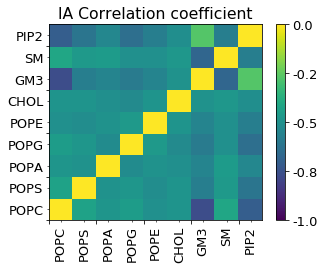

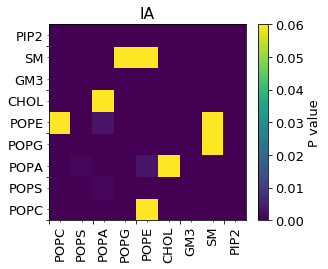

PA


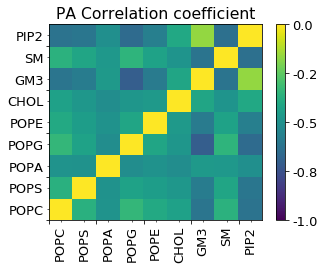

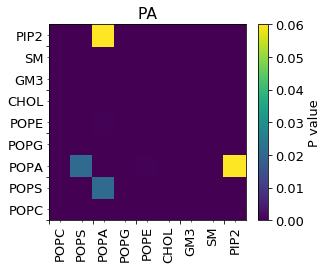

FA_G-prot


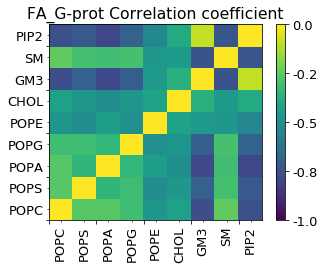

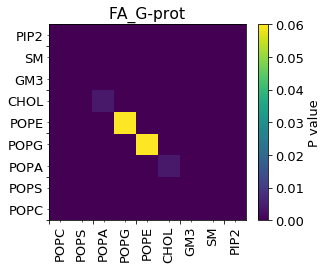

FA_no_G-prot


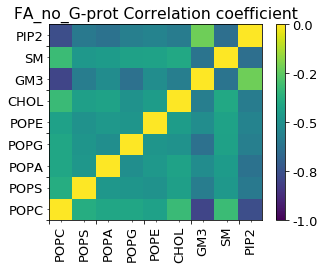

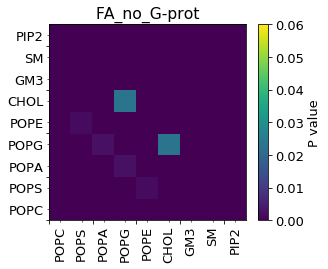

In [37]:
lipid_labels = ["POPC", "POPS", "POPA", "POPG", "POPE", "CHOL", "GM3", "SM", "PIP2"]
plt.rcParams.update({'font.size':13})

for s in systems:
    C = []
    P = []
    R = []
    Pairs = []
    for lipid in unique_lipids:
        C.append(avgNestedLists([np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,r,lipid)) for r in range(3)]))
    D = np.array(C)
    for i in range(len(unique_lipids)):
        for j in range(len(unique_lipids)):
            r, p_val = pearsonr(D[i,:], D[j,:])
            R.append(r)
            P.append(p_val)
            Pairs.append("{0:s}_{1:s}".format(unique_lipids[i], unique_lipids[j]))
    print (s)
    #print (np.array(R).shape)
    #print ('Correlation: ',R)
    #print ('pairs: ', Pairs)
    #print ('P_values : ', P)
    R_reshaped = np.array(R).reshape([9,9])
    P_reshaped = np.array(P).reshape([9,9])
    Pairs_reshaped = np.array(Pairs).reshape([9,9])
    
    #plotting
    fig,ax = plt.subplots(figsize=cm2inch(12,10))
    im = ax.pcolormesh(R_reshaped, vmin=-1, vmax=1)
    cb = fig.colorbar(im, ax=ax)
    cb.ax.set_yticklabels(["{:1.1f}".format(i) for i in cb.get_ticks()])
    # Hide major tick labels
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

    # Customize minor tick labels
    ax.xaxis.set_minor_locator(ticker.FixedLocator([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter(lipid_labels))
    ax.yaxis.set_minor_locator(ticker.FixedLocator([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(lipid_labels))
    
    for tick in ax.xaxis.get_minor_ticks():
        tick.label1.set_horizontalalignment('center')    
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
    
    
    plt.title('{0:s} Correlation coefficient'.format(s))
    plt.tight_layout()
    plt.savefig('Pearson_correlation_counts_{0:s}.png'.format(s), dpi=300, bboxs_inches='tight')
    plt.show()
    
    
    #plotting
    fig,ax = plt.subplots(figsize=cm2inch(12,10))
    im2 = ax.pcolormesh(P_reshaped, vmin=0, vmax=0.06)
    cb = fig.colorbar(im2, ax=ax)
    cb.ax.set_yticklabels(["{:1.2f}".format(i) for i in cb.get_ticks()])
    cb.set_label('P value')
    # Hide major tick labels
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

    # Customize minor tick labels
    ax.xaxis.set_minor_locator(ticker.FixedLocator([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter(lipid_labels))
    ax.yaxis.set_minor_locator(ticker.FixedLocator([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(lipid_labels))
    
    for tick in ax.xaxis.get_minor_ticks():
        tick.label1.set_horizontalalignment('center')    
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
    
    plt.title('{0:s}'.format(s))
    plt.tight_layout()
    plt.savefig('Pearson_correlation_P_val_counts_{0:s}.png'.format(s), dpi=300, bboxs_inches='tight')
    plt.show()

### t-test

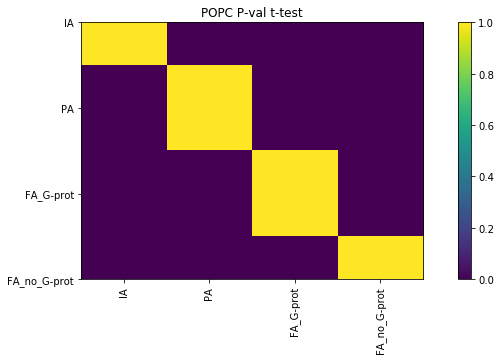

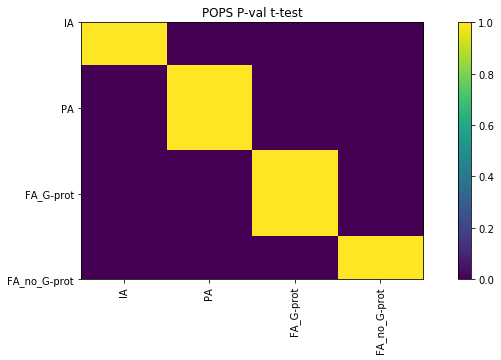

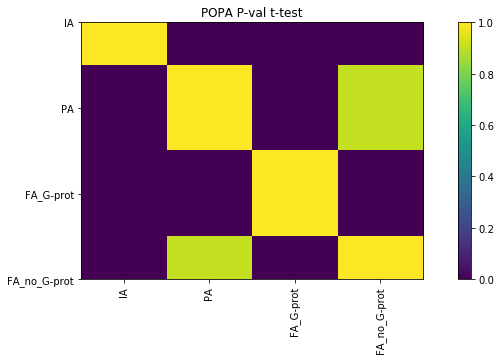

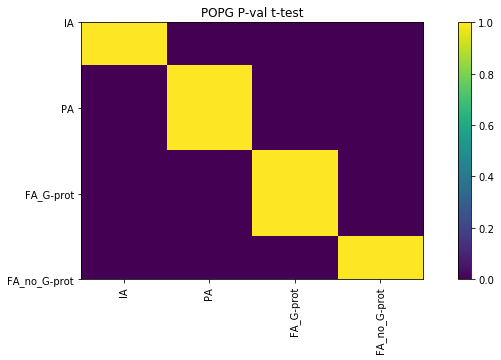

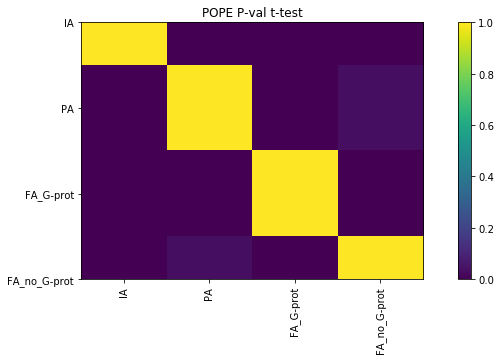

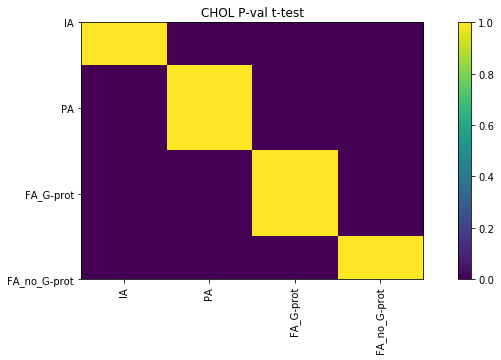

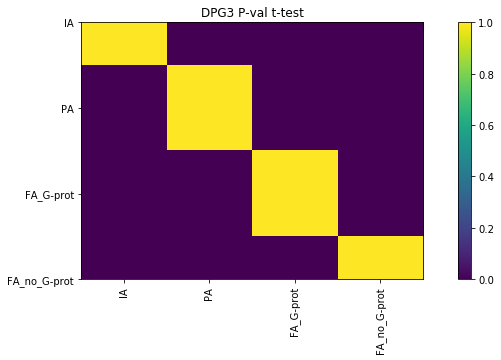

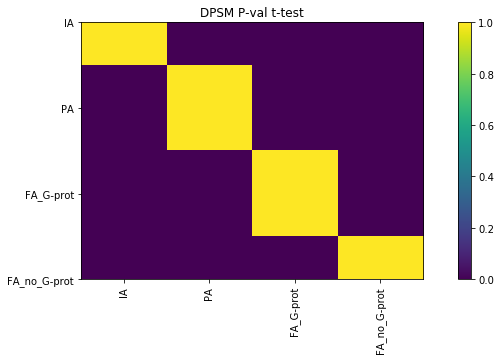

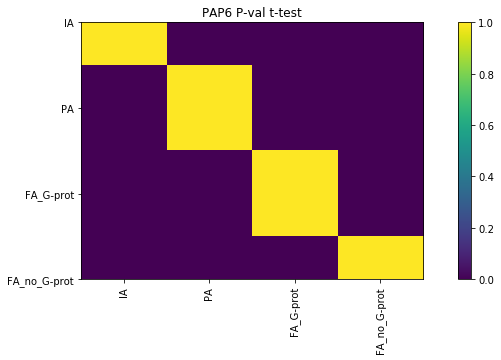

In [14]:
#f the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.
for lipid in unique_lipids:
    C = []
    P = []
    R = []
    for s in systems:
        Pairs = []
        C.append(avgNestedLists([np.loadtxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_0.7-nm.txt'.format(s,r,lipid)) for r in range(3)]))
    D = np.array(C)
    for i in range(4):
        for j in range(4):
            t_stats, p_val = ttest_ind(D[i], D[j])
            P.append(p_val)
    P_reshaped = np.array(P).reshape([4,4])
    plt.imshow(P_reshaped, interpolation='nearest', vmin=0, vmax=1)
    plt.xticks([0,1,2,3], systems, rotation=90)
    plt.yticks([0,1,2,3], systems)
    plt.colorbar()
    plt.title('{0:s} P-val t-test'.format(lipid))
    plt.savefig('T_test_P_val_counts_{0:s}.png'.format(s), dpi=300, bboxs_inches='tight')
    plt.show()

# Second shell

@jit
def count_lipids_1 (u, lipid, stride=10):
    '''Counts the number of lipids within a shell of 1.2 nm of the TMD'''
    tot_frames = len(u.trajectory[::stride])
    O = np.zeros([tot_frames])
    
    for idx, ts in enumerate(u.trajectory[::stride]):
        sel = u.select_atoms('resname {0:s} and global around 12 resid 106-394'.format(lipid))
        num_contacts = np.unique(sel.resids).shape[0]
        O[idx] = num_contacts
    return O

for idx, s in enumerate(systems):
    lipids = lipid_dir[s]
    for r in range(3):
        gro = 'GRO/{0:s}_{1:d}_nowat.gro'.format(s,r)
        xtc = 'XTC/{0:s}_{1:d}_nowat_res_center_fit.xtc'.format(s,r)
        u = md.Universe(gro,xtc)
        for lipid in lipids.split(','):
            print ('lipid:', lipid)
            llipid = lipid.translate({ord(c): None for c in string.whitespace})
            O = count_lipids_1(u, lipid)
            np.savetxt('COUNTS/{0:s}_{1:d}_number_of_{2:s}_within_1.2-nm.txt'.format(s,r,llipid), O)

# Gromacs select to counts lipids

In [8]:
unique_lipids

['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'DPG3', 'DPSM', 'PAP6']

In [9]:
import os

In [10]:
lipid_dir_group = {"CHOL":0,"PAP6":1,
                "DPG3":2,"DPSM":3,
                "POPA":9,"POPE":11,
                "POPG":12,"POPC":10,
                "POPS":13,"GCGR":4}

In [11]:
systems=["IA","PA","FA_G-prot","FA_no_G-prot"]
for s in systems:
    for lipid in unique_lipids:
        for r in range(3):
            xtc = "XTC/{0:s}_{1:d}_nowat_res_center_fit.xtc".format(s,r)
            tpr = "ORIGO_TPR/{0:s}_{1:d}.tpr".format(s,r)
            ndx = "NDX/{0:s}_{1:d}_nowat_rdf_chains.ndx".format(s,r)
            group_lipid = "{0:d}".format(lipid_dir_group[lipid])
            select_cmd = 'group {0:s} and within 0.7 of group 4'.format(group_lipid)
            output = "SELECTION/{0:s}_{1:d}_{2:s}_0.7nm_size.xvg".format(s,r,lipid)
            if os.path.exists(output):
                print ("{0:s} exists".format(output))
                continue
            else:
                print ("gmx_s select -f {0:s} -s {1:s} -n {2:s} -select '{3:s}' -os {4:s} -dt 2".format(xtc,tpr,ndx,select_cmd,output))
                os.system("gmx_s select -f {0:s} -s {1:s} -n {2:s} -select '{3:s}' -os {4:s} -dt 2".format(xtc,tpr,ndx,select_cmd,output))

SELECTION/IA_0_POPC_0.7nm_size.xvg exists
SELECTION/IA_1_POPC_0.7nm_size.xvg exists
SELECTION/IA_2_POPC_0.7nm_size.xvg exists
SELECTION/IA_0_POPS_0.7nm_size.xvg exists
SELECTION/IA_1_POPS_0.7nm_size.xvg exists
SELECTION/IA_2_POPS_0.7nm_size.xvg exists
SELECTION/IA_0_POPA_0.7nm_size.xvg exists
SELECTION/IA_1_POPA_0.7nm_size.xvg exists
SELECTION/IA_2_POPA_0.7nm_size.xvg exists
SELECTION/IA_0_POPG_0.7nm_size.xvg exists
SELECTION/IA_1_POPG_0.7nm_size.xvg exists
SELECTION/IA_2_POPG_0.7nm_size.xvg exists
SELECTION/IA_0_POPE_0.7nm_size.xvg exists
SELECTION/IA_1_POPE_0.7nm_size.xvg exists
SELECTION/IA_2_POPE_0.7nm_size.xvg exists
SELECTION/IA_0_CHOL_0.7nm_size.xvg exists
SELECTION/IA_1_CHOL_0.7nm_size.xvg exists
SELECTION/IA_2_CHOL_0.7nm_size.xvg exists
SELECTION/IA_0_DPG3_0.7nm_size.xvg exists
SELECTION/IA_1_DPG3_0.7nm_size.xvg exists
SELECTION/IA_2_DPG3_0.7nm_size.xvg exists
SELECTION/IA_0_DPSM_0.7nm_size.xvg exists
SELECTION/IA_1_DPSM_0.7nm_size.xvg exists
SELECTION/IA_2_DPSM_0.7nm_size.xvg

In [12]:
systems=["IA","PA","FA_G-prot","FA_no_G-prot"]
for s in systems:
    for lipid in unique_lipids:
        for r in range(3):
            xtc = "XTC/{0:s}_{1:d}_nowat_res_center_fit.xtc".format(s,r)
            tpr = "ORIGO_TPR/{0:s}_{1:d}.tpr".format(s,r)
            ndx = "NDX/{0:s}_{1:d}_nowat_rdf_chains.ndx".format(s,r)
            group_lipid = "{0:d}".format(lipid_dir_group[lipid])
            select_cmd = 'group {0:s}'.format(group_lipid)
            output = "SELECTION/{0:s}_{1:d}_{2:s}_total_size.xvg".format(s,r,lipid)
            if os.path.exists(output):
                print ("{0:s} exists".format(output))
                continue
            else:
                print ("gmx_s select -f {0:s} -s {1:s} -n {2:s} -select '{3:s}' -os {4:s} -dt 2".format(xtc,tpr,ndx,select_cmd,output))
                os.system("gmx_s select -f {0:s} -s {1:s} -n {2:s} -select '{3:s}' -os {4:s} -dt 2".format(xtc,tpr,ndx,select_cmd,output))

SELECTION/IA_0_POPC_total_size.xvg exists
SELECTION/IA_1_POPC_total_size.xvg exists
SELECTION/IA_2_POPC_total_size.xvg exists
SELECTION/IA_0_POPS_total_size.xvg exists
SELECTION/IA_1_POPS_total_size.xvg exists
SELECTION/IA_2_POPS_total_size.xvg exists
SELECTION/IA_0_POPA_total_size.xvg exists
SELECTION/IA_1_POPA_total_size.xvg exists
SELECTION/IA_2_POPA_total_size.xvg exists
SELECTION/IA_0_POPG_total_size.xvg exists
SELECTION/IA_1_POPG_total_size.xvg exists
SELECTION/IA_2_POPG_total_size.xvg exists
SELECTION/IA_0_POPE_total_size.xvg exists
SELECTION/IA_1_POPE_total_size.xvg exists
SELECTION/IA_2_POPE_total_size.xvg exists
SELECTION/IA_0_CHOL_total_size.xvg exists
SELECTION/IA_1_CHOL_total_size.xvg exists
SELECTION/IA_2_CHOL_total_size.xvg exists
SELECTION/IA_0_DPG3_total_size.xvg exists
SELECTION/IA_1_DPG3_total_size.xvg exists
SELECTION/IA_2_DPG3_total_size.xvg exists
SELECTION/IA_0_DPSM_total_size.xvg exists
SELECTION/IA_1_DPSM_total_size.xvg exists
SELECTION/IA_2_DPSM_total_size.xvg

IA


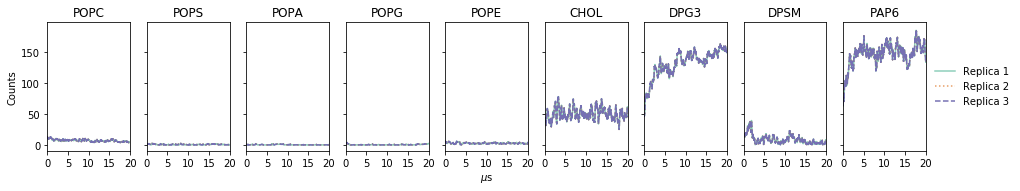

PA


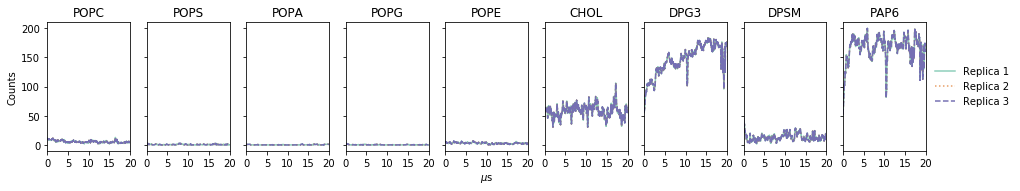

FA_G-prot


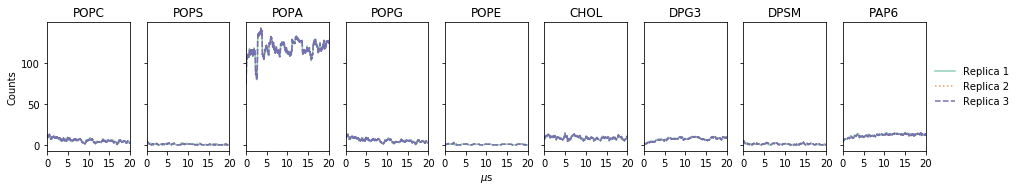

FA_no_G-prot


OSError: SELECTION/FA_no_G-prot_0_POPA_0.7nm_size.xvg not found.

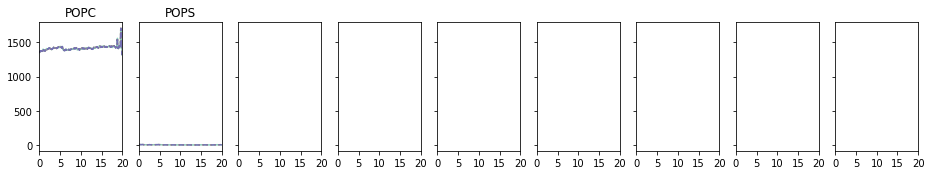

In [13]:
N = 100
systems=["IA","PA","FA_G-prot","FA_no_G-prot"]
for sdx, s in enumerate(systems):
    print(s)
    fig, ax = plt.subplots(ncols=len(unique_lipids), sharey=True, sharex=True, figsize=(cm2inch(40,6)))
    for ldx, lipid in enumerate(unique_lipids):
        #print (lipid)
        c1 = np.loadtxt("SELECTION/{0:s}_{1:d}_{2:s}_0.7nm_size.xvg".format(s,0,lipid), comments=('#','@'))
        c2 = np.loadtxt("SELECTION/{0:s}_{1:d}_{2:s}_0.7nm_size.xvg".format(s,0,lipid), comments=('#','@'))
        c3 = np.loadtxt("SELECTION/{0:s}_{1:d}_{2:s}_0.7nm_size.xvg".format(s,0,lipid), comments=('#','@'))
        #print (c1.shape)
        #ax[0,:].plot(running_mean(c1[:,1], N))
        ax[ldx].plot(running_mean(c1[:,1], N), color=color_rep[0], linestyle=line_style[0], alpha=0.5, label='Replica 1')
        ax[ldx].plot(running_mean(c2[:,1], N), color=color_rep[1], linestyle=line_style[1], alpha=0.6, label='Replica 2')
        ax[ldx].plot(running_mean(c3[:,1], N), color=color_rep[2], linestyle=line_style[2], label='Replica 3')
        ax[ldx].set_title(lipid)
        ax[ldx].set_xlim(0,20000)
        ax[ldx].set_xticks([0, 5000,10000, 15000, 20000])
        ax[ldx].set_xticklabels([0, 5,10,15,20])
    ax[4].set_xlabel(r'$\mu$s')
    ax[0].set_ylabel('Counts')
    #ax[0].set_ylim(0,200)
    ax[8].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False)
    #plt.savefig('SELECTION/COUNTS_{0:s}.png'.format(s), dpi=300, bbox_inches='tight')
    plt.show()